This problem set is provided to help you get used to PyTorch.

Only fill parts marked with "`Your code here`" comments, don't erase or change the rest.

<font color="red">**You are NOT ALLOWED to:**</font>
* use NumPy or any other tensor library except PyTorch;
* emulate PyTorch tensors (i.e. large arrays of numbers) with lists or tuples;
* emulate any tensor functionality with other libraries/loops/indexing if it's directly native to PyTorch. Example:

```python
x = torch.rand(1_000_000)

# Wrong: slow and unreadable
for idx in range(x.numel()):
    x[idx] = math.sqrt(x[idx])

# Correct
x.sqrt_()
```

# Homework 2, *part 1*
### (40 points total)

In this part only, you are <font color="red">**NOT ALLOWED**</font> to use any PyTorch submodules, including
* `torch.nn`,
* `torch.nn.functional` (in general, try to always avoid using it),
* `torch.optim`,
* `torch.utils.data`.

Instead, use only PyTorch core functions, such as `torch.avg_pool1d(x)` or `torch.no_grad()`. Where possible, use special operators syntax (e.g. `x @ y`, `x += 17`, `x[None]`) or tensor methods (e.g. `x.to(y)`, `x.prelu()`, `x.copy_(y)`).

**You are required** to format your notebook cells so that `Run All` command on a fresh notebook
* displays all the required plots in tasks 1 and 2;
* within 15 seconds, **reliably** trains your model in task 3 to the desired accuracy and reports the accuracy reached.

In [0]:
import numpy as np               # results verification during grading
import math                      # Pi
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt  # 2D plot in task 1
%matplotlib inline

import torch
assert torch.__version__ >= '1.3.0'

In [8]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/Deep Learning 2020 -- Home Assignment 2")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.insert(0, str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Import the custom libraries
from animation import Animation    # animations in task 2
from notmnist import load_notmnist # dataset for task 3

While learning PyTorch, you will have lots of questions, e.g.

* how to choose between `.sqrt()` and `.sqrt_()`,
* when to use `.view()` and how is it different from `.reshape()`,
* which `dtype` to use etc.

To find the answers, you are expected to study [documentation](https://pytorch.org/docs/stable/index.html) and google a lot.

If this is your first PyTorch experience, you may want to [start here](https://pytorch.org/tutorials/).

Quick documentation on functions and modules is available with `?` and `help()`, like so:

In [10]:
help(torch.sqrt)

Help on built-in function sqrt:

sqrt(...)
    sqrt(input, out=None) -> Tensor
    
    Returns a new tensor with the square-root of the elements of :attr:`input`.
    
    .. math::
        \text{out}_{i} = \sqrt{\text{input}_{i}}
    
    Args:
        input (Tensor): the input tensor.
        out (Tensor, optional): the output tensor.
    
    Example::
    
        >>> a = torch.randn(4)
        >>> a
        tensor([-2.0755,  1.0226,  0.0831,  0.4806])
        >>> torch.sqrt(a)
        tensor([    nan,  1.0112,  0.2883,  0.6933])



In [0]:
# to close the Jupyter help bar, press `Esc` or `q`
?torch.cat

## Task 1 (3 points)

**Use 64-bit floating point tensors for this task**.

$\rho(\theta)$ is defined in polar coordinate system:

$$\rho(\theta) = (1 + 0.9 \cdot \cos{8\theta} ) \cdot (1 + 0.1 \cdot \cos{24\theta}) \cdot (0.9 + 0.05 \cdot \cos {200\theta}) \cdot (1 + \sin{\theta})$$

1. Create a regular grid of 1000 values of $\theta$ between $-\pi$ and $\pi$.
2. Compute $\rho(\theta)$ at these points.
3. Convert the result into Cartesian coordinates ([see here how](http://www.mathsisfun.com/polar-cartesian-coordinates.html)).

In [0]:
theta = torch.linspace(-math.pi, math.pi, 1000)
assert theta.shape == (1000,)

rho = (1 + 0.9*torch.cos(8*theta)) * (1 + 0.1*torch.cos(24*theta)) * (0.9 + 0.05*torch.cos(200*theta)) * (1 + torch.sin(theta))
assert torch.is_same_size(rho, theta)

x = rho * torch.cos(theta)
y = rho * torch.sin(theta)

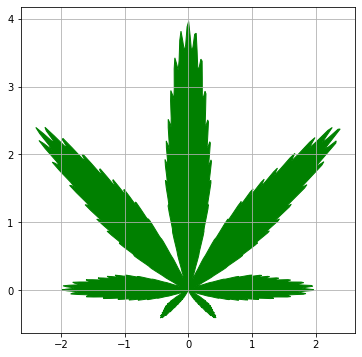

In [16]:
# Run this cell and make sure the plot is correct
plt.figure(figsize=(6,6))
plt.fill(x, y, color='green')
plt.grid()

In [17]:
assert \
    np.allclose(x.sum(), -1.9854999999997989, atol=1e-4) and \
    np.allclose(y.mean(), 0.44955, atol=1e-4), \
    "Task 1: you've made an error somewhere"
print("Task 1: well done!")

Task 1: well done!


## Task 2 (7 points)

We will implement [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway's_Game_of_Life) in PyTorch.

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)

In case you skipped the above hyperlink, here are the rules:
* You have a 2D grid of cells, where each cell is "alive" or "dead" (has a value of `1` or `0` respectively).
* At each step in time, the so-called "generation update" happens:
  * any alive cell that has 2 or 3 neighbors survives, otherwise (0, 1 or 4+ neighbors) it dies;
  * any cell with exactly 3 neighbors becomes alive if it was dead.

You are given a reference numpy implementation of the generation update. Your task is to convert it to PyTorch. Try to avoid datatype conversions.

In [0]:
from scipy.signal import correlate2d as conv2d

def game_of_life_update_numpy(alive_map):
    """
    Game of Life update function.
    
    alive_map:
        `numpy.ndarray`, ndim == 2, dtype == `np.int64`
        The game map containing 0s (dead) an 1s (alive).
    """
    # Count neighbours with convolution
    conv_kernel = np.array([[1,1,1],
                            [1,0,1],
                            [1,1,1]], dtype=np.int64)
    
    num_alive_neighbors = conv2d(alive_map, conv_kernel, mode='same')
    
    # Apply game rules
    born = np.logical_and(num_alive_neighbors == 3, alive_map == 0)
    survived = np.logical_and(np.isin(num_alive_neighbors, [2,3]), alive_map == 1)
    
    np.copyto(alive_map, np.logical_or(born, survived))

In [0]:
def game_of_life_update_torch(alive_map):
    """
    PyTorch version of `game_of_life_update_numpy`.
    
    alive_map:
        `torch.tensor`, ndim == 2, dtype == `torch.int64`
        The game map containing 0s (dead) an 1s (alive).
    """
    # Torch does not have logical_and operation, but one can apply just usual comparison via &(and), |(or) or torch.eq:
    # https://stackoverflow.com/questions/54590661/pytorch-equivalent-of-numpys-logical-and-and-kin
    conv_kernel = torch.Tensor([[1,1,1],
                                [1,0,1],
                                [1,1,1]])
    

    num_alive_neighbors = torch.conv2d(alive_map.reshape(1, 1, alive_map.shape[0], alive_map.shape[1]).float(), 
                                       conv_kernel.reshape(1, 1, conv_kernel.shape[0], conv_kernel.shape[1]).float(),
                                       padding = 1) # mind the size of kernel - or we'll get dimension mismatch (98 vs 100)
    
    # Apply game rules
    #print(torch.eq(num_alive_neighbors,3), '\n', (num_alive_neighbors == 3))

    born = (num_alive_neighbors == 3) & (alive_map == 0)

    alive_neghbours = (num_alive_neighbors == 2) | (num_alive_neighbors == 3)

    survived = alive_neghbours & (alive_map == 1)

    result = born | survived
    #print(born.numpy(), '\n', survived.numpy())
    #print(result.numpy())

    alive_map.data = result.reshape(alive_map.shape[0], alive_map.shape[1]) # I tried to update alive_map itself, but apparently you must update alive_map.data
    #alive_map = result.clone().detach()
    # Your code here

In [65]:
for _ in range(10):
    # Generate a random initial map
    alive_map_numpy = np.random.choice([0, 1], p=(0.5, 0.5), size=(100, 100))
    alive_map_torch = torch.from_numpy(alive_map_numpy).clone()

    '''
    print('Map shape:', alive_map_numpy.shape, "; Type: ", alive_map_torch.dtype)
    print('Original map:')
    print(alive_map_numpy)
    '''

    game_of_life_update_numpy(alive_map_numpy)
    game_of_life_update_torch(alive_map_torch)

    '''
    # ubogaya otladka
    print('Numpy map:')
    print(alive_map_numpy)
    print('Torch map:')
    print(alive_map_torch.numpy())
    print(alive_map_torch.numpy().shape)
    '''
    
    # Results must be identical
    assert np.allclose(alive_map_torch.numpy(), alive_map_numpy), \
        "Your PyTorch implementation doesn't match numpy_update."

print("Task 2: well done!")

Task 2: well done!


In [66]:
animation = Animation(monochrome=True)

# Initialize game field
np.random.seed(666)
alive_map = np.random.choice([0, 1], size=(100, 100))
alive_map = torch.from_numpy(alive_map)

for _ in range(101):
    animation.add_image((alive_map * 255).byte().numpy()[:, :, None])
    game_of_life_update_torch(alive_map)

animation.display()

In [67]:
animation = Animation(monochrome=True)

# A fun setup for your amusement
alive_map = np.arange(100) % 2 + np.zeros((100, 100), dtype=np.int64)
alive_map[48:52, 50] = 1

alive_map = torch.from_numpy(alive_map)

for _ in range(150):
    animation.add_image((alive_map * 255).byte().numpy()[:, :, None])
    game_of_life_update_torch(alive_map)

animation.display()

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE)

## Task 3 (30 points)

You have to solve yet another character recognition problem: *notMNIST* dataset of 10 letters and ~14 000 train samples.

For this, we ask you to build a multilayer perceptron (*i.e. a neural network of linear layers*) from scratch using **low-level** PyTorch interface.

Requirements:
1. at least 82% validation accuracy,
2. at least 2 linear layers,
3. no convolutions,
3. use [softmax followed by categorical cross-entropy](https://gombru.github.io/2018/05/23/cross_entropy_loss/).

Tips:

* Don't use the structures from homework 1 (`Sequential`, `.forward()` etc.). I suggest that your `NeuralNet.predict()` consists of 5-7 lines.
* Pick random batches (either shuffle data before each epoch or sample each batch randomly).
* Do not initialize weights with zeros ([learn why](https://stats.stackexchange.com/questions/27112/danger-of-setting-all-initial-weights-to-zero-in-backpropagation)). Gaussian noise with small variance will do.
* 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve.
* To improve accuracy, consider changing layers' sizes, nonlinearities, optimization methods, weights initialization.
* Don't use GPU yet.

Happy googling!

In [12]:
letters = 'ABCDEFGHIJ'
X_train, y_train, X_val, y_val = map(torch.tensor, load_notmnist(letters=letters))
X_train.squeeze_()
X_val.squeeze_();

Extracting...
Parsing... (it's OK if <10 images are broken)
Found broken image: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
Found broken image: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png


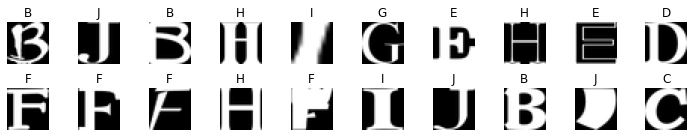

In [13]:
fig, axarr = plt.subplots(2, 10, figsize=(10, 2))

for idx, ax in enumerate(axarr.ravel()):
    ax.imshow(X_train[idx], cmap='gray')
    ax.axis('off')
    ax.set_title(letters[y_train[idx]])

fig.tight_layout()

In [0]:
np.random.seed(666)
torch.manual_seed(666);

The cell below has an example layout for encapsulating your neural network. Feel free to modify the interface if you need to (add arguments, add return values, add methods etc.). For example, you may want to add a method `do_gradient_step()` that executes one optimization algorithm (SGD / Adadelta / Adam / ...) step.

In [0]:
class NeuralNet:
    def __init__(self):
        # Your code here

        image_size = 784 # 28*28
        out_size = 10 # 10 classes
        hidden_size = 50
        var = 1e-2
        self.lr = 1e-3
        k = 1

        # Weights
        self.w_1 = torch.zeros(image_size, hidden_size).data.normal_(0, var)
        self.w_2 = torch.zeros(hidden_size, out_size).data.normal_(0, var)

        # Biases
        self.b_1 = torch.zeros(hidden_size).data.normal_(0, var)
        self.b_2 = torch.zeros(out_size).data.normal_(0, var)
        
        # Since we want to use as much torch advantages as we can, we wil use auto grad, so we need now to put "requires grad" status as True
        #
        # self.w_1 = torch.zeros(image_size, hidden_size, requires_grad = True).data.normal_(0, var) - was terrible mistake!
        # I spent a LOT of time trying to figure out why my loss ~90 all the time and accuracy ~10%, the reason was in wrong order of normalization and requires_grad
        # I suppose in case of wrong order gradients could not be existed for some prenormalized random(!) values, but not 100% sure
        grad_state = True

        # Weights
        self.w_1.requires_grad_(grad_state)
        self.w_2.requires_grad_(grad_state)

        # Biases
        self.b_1.requires_grad_(grad_state)
        self.b_2.requires_grad_(grad_state)

    def predict(self, images, act = 0):
        """
        images:
            `torch.tensor`, shape == `batch_size x height x width`, dtype == `torch.float32`
            A minibatch of images -- the input to the neural net.
        
        return:
        prediction:
            `torch.tensor`, shape == `batch_size x 10`, dtype == `torch.float32`
            The probabilities of each input image to belong to each of the dataset classes.
            Namely, `output[i, j]` is the probability of `i`-th
            minibatch sample to belong to `j`-th class.
        """

        images = images.reshape(images.size(0), -1) # here we should resize
        out = torch.zeros_like(images)
        # here you can choose activation function
        activation_list = ['ReLu', 'Tanh', 'LeakyReLU', 'SoftPlus']

        # Just 2 layers are more than enough apparently

        lay_1 = images @ self.w_1 + self.b_1
        activation_layer_1 = self.activation(lay_1, activation_list[act])
        lay_2 = activation_layer_1 @ self.w_2 + self.b_2

        out = torch.softmax(lay_2, dim = 1) # I think it's ok to use built-in softmax, nevertheless it is just some simple technical thing

        return out 
    '''
    def forward(self):
        return out
    '''
    #def backward(self):
    #    self.loss.backward() # we do not need this

    def criterion(self, pred, labels):
        loss = (labels * torch.log(pred)).sum()
        N = labels.size(0)
        return  - loss / N

    def zero_grads(self):
        # Essential to zero gradients befor starting prediction
        self.w_1.grad = torch.zeros_like(self.w_1)
        self.w_2.grad = torch.zeros_like(self.w_2)

        self.b_1.grad = torch.zeros_like(self.b_1)
        self.b_2.grad = torch.zeros_like(self.b_2)

    def do_gradient_step(self, lr = 1e-3):
        self.lr = lr # Gradient descent, but also had some options for adam (but apparently it was enough)
        self.w_1.data = self.w_1.data - self.lr * self.w_1.grad
        self.w_2.data = self.w_2.data - self.lr * self.w_2.grad

        self.b_1.data = self.b_1.data - self.lr * self.b_1.grad
        self.b_2.data = self.b_2.data - self.lr * self.b_2.grad
    '''
    def do_adam(self, lr = 1e-2, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8):
        state = {}
        state.setdefault('m', {})
        state.setdefault('v', {})
        state.setdefault('t', 0)
        state['t'] += 1

        var_index = 0
        patameter_list = [self.w_1, self.b_1, self.w_2, self.b_2]
        lr_t = lr * math.sqrt(1 - beta2 ** state['t']) / (1 - beta1 ** state['t'])
        for parameter in patameter_list:
            current_var = parameter
            current_grad = current_var.grad

            var_first_moment = state['m'].setdefault(var_index, torch.zeros_like(current_grad))
            var_second_moment = state['v'].setdefault(var_index, torch.zeros_like(current_grad))

            g = current_grad
            np.add(np.multiply(beta1, var_first_moment), np.multiply((1 - beta1), g), out = var_first_moment)
            np.add(np.multiply(beta2, var_second_moment), np.multiply(np.multiply((1 - beta2), g), g), out = var_second_moment)
            update_var = np.multiply(lr_t, np.divide(var_first_moment, np.add(np.sqrt(var_second_moment), epsilon)))
            np.subtract(current_var, update_var, out = current_var)
                
            var_index = var_index + 1
        '''
    
    def activation(self, input, name = 'ReLu'):
    
        out = torch.zeros_like(input)

        if name == 'ReLu':
            out = torch.max(input, torch.zeros_like(input))
            #out = torch.ReLU(input)

        if name == 'Tanh':
            out = torch.tanh(input)

        if name == 'LeakyReLU':
            slope = 0.03
            out = torch.max(input * slope, input)
            #out = torch.LeakyReLU(input, slope)

        if name == 'SoftPlus':
             out = torch.log(torch.exp(input) + 1)
             #torch.SoftPlus(input)
             
        return out

        # Your code here

    # Your code here

In [0]:
# Batch generator (random-based) from first HW
def get_batches(X, Y, batch_size):
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx] 

def accuracy(model, images, labels):
    """
    model:
        `NeuralNet`
    images:
        `torch.tensor`, shape == `N x height x width`, dtype == `torch.float32`
    labels:
        `torch.tensor`, shape == `N`, dtype == `torch.int64`
        Class indices for each sample in `images`.
    
    return:
    value:
        `float`
        The fraction of samples from `images` correctly classified by `model`.
        `0 <= value <= 1`.
        
    """
    # inspired by one of the seminars, namely by function 'compute_accuracy'
    logits = model.predict(images)
    y_pred = torch.argmax(logits, dim=1)
    #y_true_on_device = y_true.to(device) #- no need on CPU
    accuracy = (y_pred == labels).float().mean()
    return accuracy

    # Your code here   

In [181]:
model = NeuralNet()
%time
torch.set_num_threads(1)
N = 50
n_classes = 10
batch_size = 128 
loss_history = []
lr = 1e-2 # kind of optimal, because 1e-3 is too much (vice versa)
act = 2 # 0, 1, 2, 3 : ReLU, Tanh, LekyReLU, SoftPlus
for n_epoch in tqdm(range(N)):
    for X_batch, y_batch in get_batches(X_train, y_train, batch_size):

        # Zero gradients
        model.zero_grads()

        # Prediction and usage of criterion
        pred = model.predict(X_batch, act) # here you can choose some options for activation functions
        Loss = model.criterion(pred, torch.eye(n_classes)[y_batch]) # I googled this 'onehotencoder' for poor people

        # Backward step
        Loss.backward()

        # Optimizer
        model.do_gradient_step(lr = lr)
        #model.do_adam()

        loss_history.append(Loss.item())

    # Tried to implement brand-new feature with decreasing learning rate - loss slightly increases, but accuracy increases also!
    if (n_epoch % 20 == 0):
        lr /= 1.5

    if (n_epoch % 5 == 0):
        print('Epoch  №' , n_epoch, '| Loss ', Loss.item())
# Your code here (train the model)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.7 µs


Epoch  № 0 | Loss  2.094214916229248
Epoch  № 5 | Loss  0.5204380750656128
Epoch  № 10 | Loss  0.33064553141593933
Epoch  № 15 | Loss  0.356059193611145
Epoch  № 20 | Loss  0.508725106716156
Epoch  № 25 | Loss  0.3357389569282532
Epoch  № 30 | Loss  0.49222004413604736
Epoch  № 35 | Loss  0.2400449812412262
Epoch  № 40 | Loss  0.25939568877220154
Epoch  № 45 | Loss  0.30965960025787354



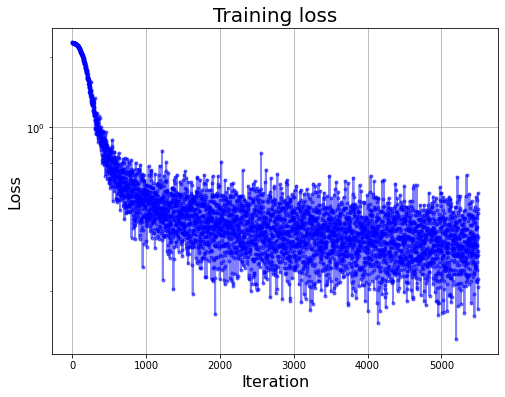

In [182]:
plt.figure(figsize=(8, 6))
plt.grid('on')    
plt.title('Training loss', FontSize = 20)
plt.xlabel('Iteration', FontSize = 16)
plt.ylabel('Loss', FontSize = 16)
plt.semilogy(loss_history,  'b.-', lw = 2, alpha = 0.5)
plt.show()

In [183]:
train_accuracy = accuracy(model, X_train, y_train) * 100
val_accuracy = accuracy(model, X_val, y_val) * 100
print("Training accuracy: %.2f, validation accuracy: %.2f" % (train_accuracy, val_accuracy))

assert val_accuracy >= 82.0, "You have to do better"
print("Task 3: well done!")

Training accuracy: 90.89, validation accuracy: 89.70
Task 3: well done!
